In [ ]:
# Analysis workflow adopted & modified from https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html &
# Data collected & inspo from :https://divingintogeneticsandgenomics.com/post/neighborhood-cellular-niches-analysis-with-spatial-transcriptome-data-in-seurat-and-bioconductor/

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

In [ ]:
# Check working directory
import os
os.getcwd()

In [3]:
# Set working directory to where the files are
new_directory = "../output-XETG00068__0010617__Region_1__20231101__013739"
os.chdir(new_directory)

In [5]:
adata = sc.read_10x_h5("cell_feature_matrix.h5")
df = pd.read_csv("cells.csv")
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [6]:
adata

AnnData object with n_obs × n_vars = 103951 × 314
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [65]:
# Subset data to region of interest
# Create a boolean mask based on spatial coordinates
x_min = 2500
x_max = 4400
y_min = 700
y_max = 2000

criteria = (
    (adata.obs['x_centroid'] >= x_min) & (adata.obs['x_centroid'] <= x_max) &
    (adata.obs['y_centroid'] >= y_min) & (adata.obs['y_centroid'] <= y_max)
)

# Subset the AnnData object based on the spatial criteria
subset_adata = adata[criteria, :]

In [66]:
subset_adata.obs['transcript_counts'] # 11k cells

adjnbpgn-1     67
adjngema-1    115
adjnhkef-1     67
adkacmbc-1    150
adkagmje-1     97
             ... 
mmdhdagj-1    121
mmdheogm-1     63
mmdibfnf-1    211
mmdjcnbe-1    194
mmdjdeaa-1    131
Name: transcript_counts, Length: 11444, dtype: int64

In [67]:
# CALCULATING QC METRICS
sc.pp.calculate_qc_metrics(subset_adata, percent_top=(10, 20, 50, 150), inplace=True)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [68]:
cprobes = (
   subset_adata.obs["control_probe_counts"].sum() / subset_adata.obs["total_counts"].sum() * 100
)
cwords = (
    subset_adata.obs["control_codeword_counts"].sum() / subset_adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.0029309937489896956
Negative decoding count % : 0.00373035568053234


/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

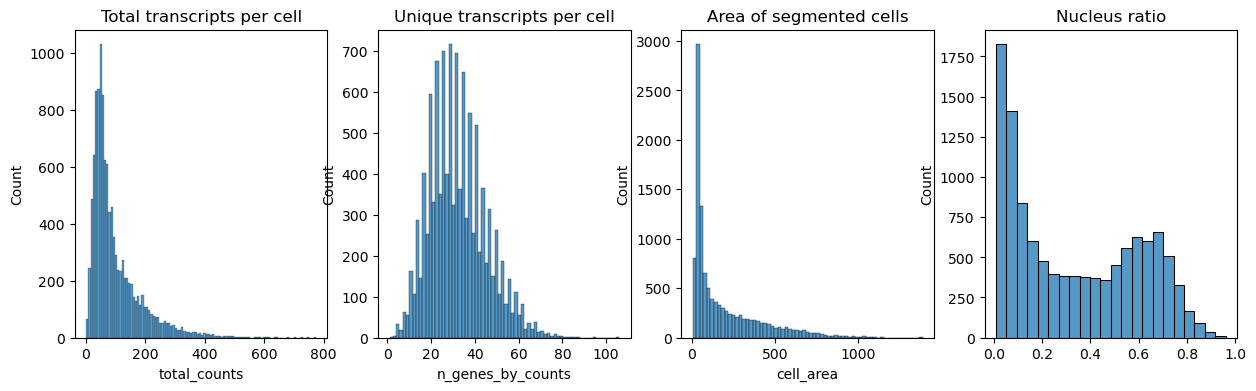

In [69]:
# Plotting QC metrics - again, also provided on the analysis_summary.html
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    subset_adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    subset_adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    subset_adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    subset_adata.obs["nucleus_area"] / subset_adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(0.0, 700.0)

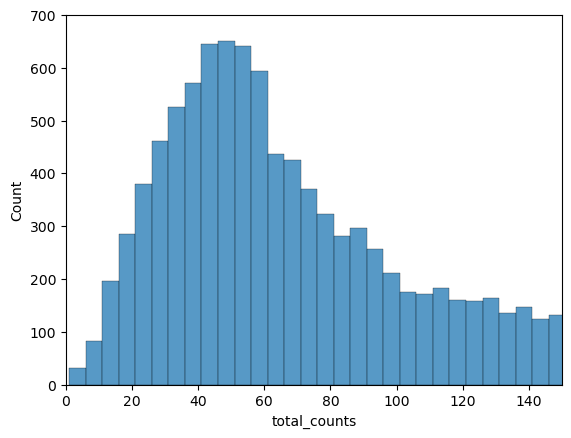

In [74]:
sns.histplot(
    subset_adata.obs["total_counts"],
    kde=False,
    binwidth=5)

plt.xlim(0, 150)
plt.ylim(0, 700)

In [75]:
# Filtering cells/genes based on QC graph above. Filter criteria can be cell area, DAPI signal or minium of unique transcripts
sc.pp.filter_cells(subset_adata, min_counts=12) # The Xenium anlysis summary would help
sc.pp.filter_genes(subset_adata, min_cells=5) #min number of cells expresed required for a gene to pass filtering; min # of counts required for a gene to pass filtering. Using Xenium explorer to help

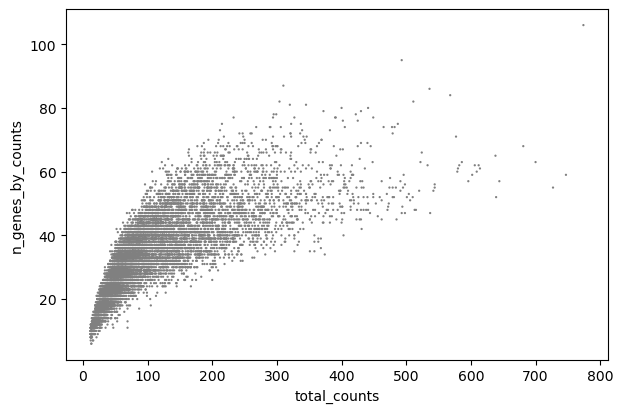

In [77]:
# Following scanpy preprocessing workflow https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
sc.pl.scatter(subset_adata, x='total_counts', y='n_genes_by_counts') # check whether to remove more

In [78]:
# Normalisation using default setting
subset_adata.layers["counts"] = subset_adata.X.copy()
sc.pp.normalize_total(subset_adata, inplace=True)

# Logarithmize the data
sc.pp.log1p(subset_adata)

# scale the data for visualisation step later
subset_adata.layers['scaled'] = sc.pp.scale(subset_adata, copy=True).X

# Dimentionality reduction
sc.pp.pca(subset_adata) 

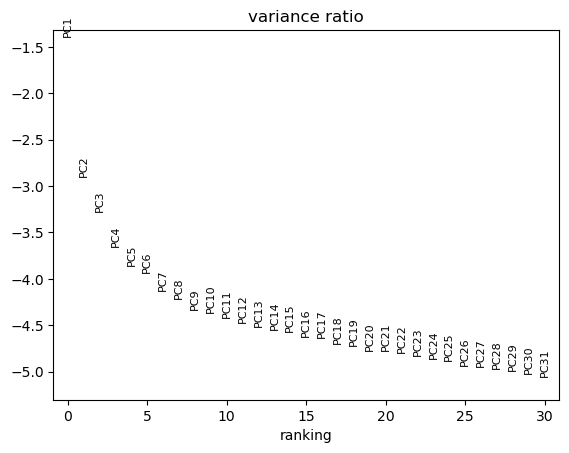

In [81]:
sc.pl.pca_variance_ratio(subset_adata, log=True)

In [82]:
# can read more about setting the parameter at https://umap-learn.readthedocs.io/en/latest/parameters.html
sc.pp.neighbors(subset_adata,
               n_neighbors =15) # n_neighbour default = 15, can set between 2-200, controls how UMAP balances local vs global structure in the data; small n-neigbours = focus more on local structure, 

In [83]:
sc.tl.umap(subset_adata)

In [84]:
# Clustering by leiden, using different resolutions
sc.tl.leiden(subset_adata, key_added = "leiden_1.0") # default resolution in 1.0

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


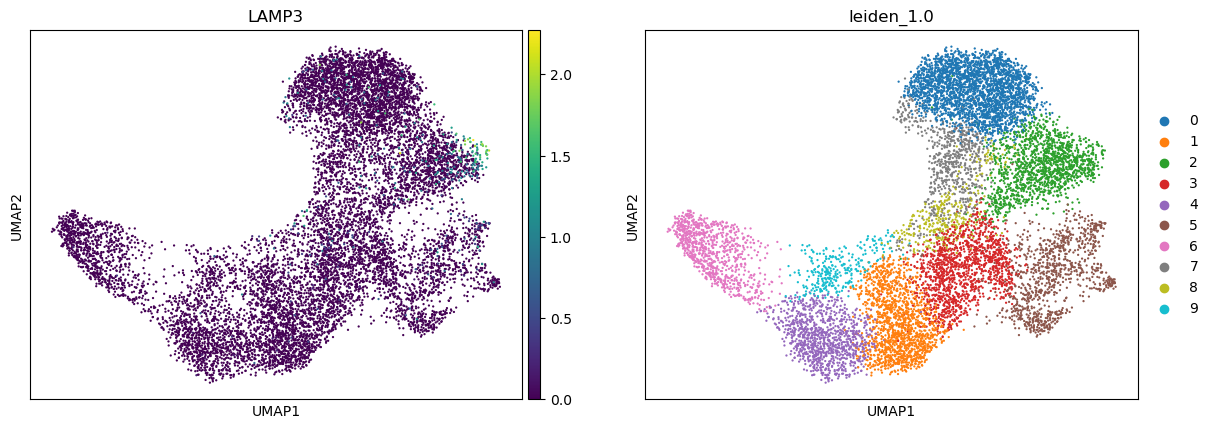

In [93]:
sc.pl.umap(subset_adata, color=['LAMP3','leiden_1.0'])

In [94]:
resolutions = [1.6, 1.8, 2.0, 2.2, 2.5, 3.0, 4.0, 4.5]

for resolution in resolutions:
    key_added = f"leiden_{resolution}"
    sc.tl.leiden(subset_adata, resolution=resolution, key_added=key_added)

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


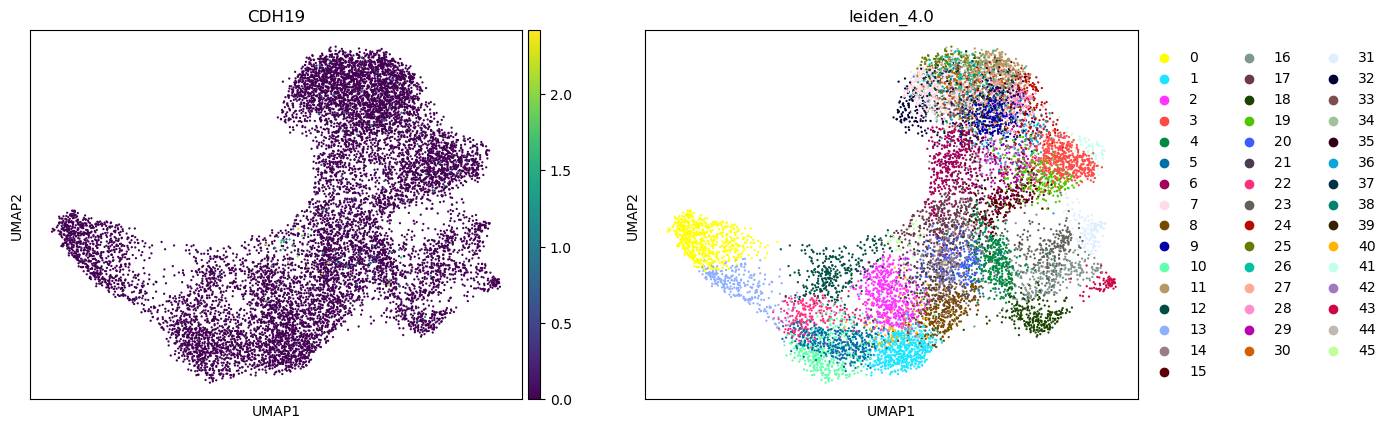

In [100]:
sc.pl.umap(subset_adata, color = ['CDH19','leiden_4.0'])

In [ ]:
# Find Marker genes
sc.tl.rank_genes_groups(subset_adata, 'leiden_4.0', method='wilcoxon')
sc.pl.rank_genes_groups(subset_adata, n_genes=25, sharey=False)

In [ ]:
# CLUSTER ANNOATION - condense version for visualisation
cluster_anno_condense = {
   "0": "Malignant_epi",
    "13": "Malignant_epi",
    "43": "Endothelial",
    "16": "Endothelial",
    "18": "Pericytes",
    "14": "Plasma",
    "4": "FRCs",
    "20": "FRCs",
    "12": "Tam_SPP1+",
    "21": "myCAFs", #IGF1
    "10": "myCAFs_CXCL14+",
    "5": "myCAFs",
    "22": "myCAFs",
    "2": "myCAFs",
    "8": "myCAFs",
    "1": "myCAFs",
    "40": "myCAFs",
    "32": "B_MS4A1+", #_CXCL13+",
    "6": "B_MS4A1+",
    "39": "B_MS4A1+",
    "36":"B_MS4A1+",
    "37": "B_MS4A1+",
    "7": "B_MS4A1+",
    "25":"B_MS4A1+",
    "26": "B_MS4A1+",
    "30": "B_MS4A1+",
    "27": "B_MS4A1+",
    "44": "B_MS4A1+",
    "9": "B_MS4A1+",
    "33": "B_MS4A1+",
    "34": "B_MS4A1+",
    "38": "B_MS4A1+",
    "11": "B_MS4A1+",
    "35": "B_MS4A1+",
    "24": "B_MS4A1+",
    "28": "B_MS4A1+",
    "41": "DCs_LAMP3+",
    "42": "B_MS4A1+",
    "29": "Plasma",
    "15": "CD8A+_GZMK+_CCL5+",
    "3": "CD2+_IL7R+_TCF7+",
    "19": "CD8A+_GZMK+_CCL5+",
    "23": "Endothelial", #stalk like
    "31": "Endothelial",
    "17": "Tam_C1QC+",
    "45": "Schwann"
 }

In [206]:
# CLUSTER ANNOATION - endothelial subsets
cluster_anno_revised = {
   "0": "Malignant_epi",
    "13": "Malignant_epi",
    "43": "Endothelial_VEGFC+",
    "16": "Endothelial",
    "18": "Pericytes",
    "14": "Plasma",
    "4": "FRCs",
    "20": "FRCs",
    "12": "TAMs_SPP1+/OLR1+", #checked
    "21":"CAFs_MYO", #checked
    "10": "CAFs_MYO_CXCL14+", #checked
    "5": "CAFs_MYO", #checked
    "22": "CAFs_MYO", #checked
    "2": "CAFs_MYO", #checked
    "8": "CAFs_MYO", #checked
    "1": "CAFs_MYO", #checked
    "40": "CAFs_MYO", #checked
    "32": "B_MS4A1+", #_CXCL13+",
    "6": "B_MS4A1+",
    "39": "B_MS4A1+",
    "36":"B_MS4A1+",
    "37": "B_MS4A1+",
    "7": "B_MS4A1+",
    "25":"B_MS4A1+",
    "26": "B_MS4A1+",
    "30": "B_MS4A1+",
    "27": "B_MS4A1+",
    "44": "B_MS4A1+",
    "9": "B_MS4A1+",
    "33": "B_MS4A1+",
    "34": "B_MS4A1+",
    "38": "B_MS4A1+",
    "11": "B_MS4A1+",
    "35": "B_MS4A1+",
    "24": "B_MS4A1+",
    "28": "B_MS4A1+",
    "41": "DCs_LAMP3+",
    "42": "B_MS4A1+",
    "29": "Plasma",
    "15": "CD8A+_GZMK+_CCL5+",
    "3": "CD2+_IL7R+_TCF7+",
    "19": "CD8A+_GZMK+_CCL5+",
    "23": "Endothelial_ACKR1+_CCL19+", #stalk like
    "31": "Endothelial_ACKR1+_CCL19+",
    "17": "TAMs_C1QC+",
    "45": "Schwann"
 }

In [ ]:
subset_adata.obs["anno_condense"] = subset_adata.obs['leiden_4.0'].map(cluster_anno_condense)
subset_adata.obs['leiden_4.0'].map(cluster_anno_condense)

adjnbpgn-1           FRCs
adjngema-1           FRCs
adjnhkef-1           FRCs
adkacmbc-1           FRCs
adkagmje-1           FRCs
                 ...     
mmdhdagj-1    Endothelial
mmdheogm-1    Endothelial
mmdibfnf-1         myCAFs
mmdjcnbe-1    Endothelial
mmdjdeaa-1    Endothelial
Name: leiden_4.0, Length: 11296, dtype: object

In [207]:
subset_adata.obs["anno_revised"] = subset_adata.obs['leiden_4.0'].map(cluster_anno_revised)
subset_adata.obs['leiden_4.0'].map(cluster_anno)

adjnbpgn-1           FRCs
adjngema-1           FRCs
adjnhkef-1           FRCs
adkacmbc-1           FRCs
adkagmje-1           FRCs
                 ...     
mmdhdagj-1    Endothelial
mmdheogm-1    Endothelial
mmdibfnf-1       CAFs_MYO
mmdjcnbe-1    Endothelial
mmdjdeaa-1    Endothelial
Name: leiden_4.0, Length: 11296, dtype: object

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype 

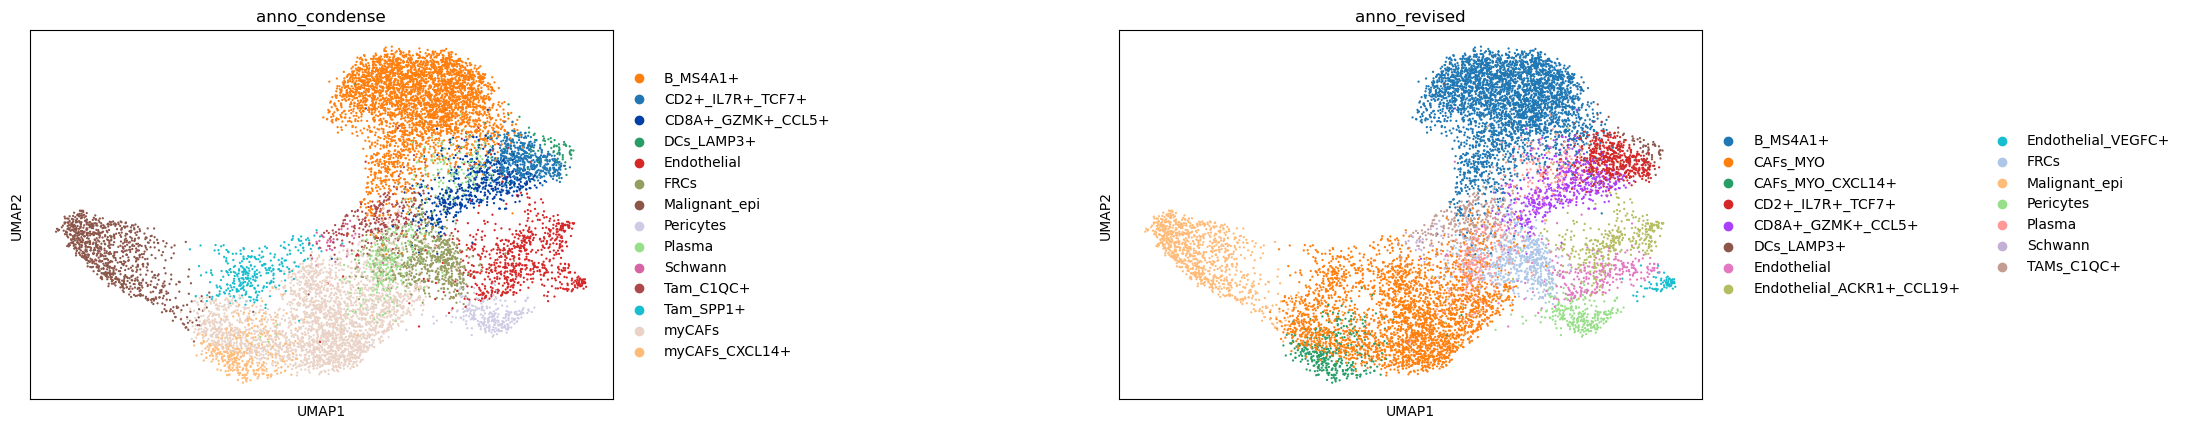

In [ ]:
sc.pl.umap(subset_adata, color=["anno_condense", "anno_revised"], wspace = 0.7)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

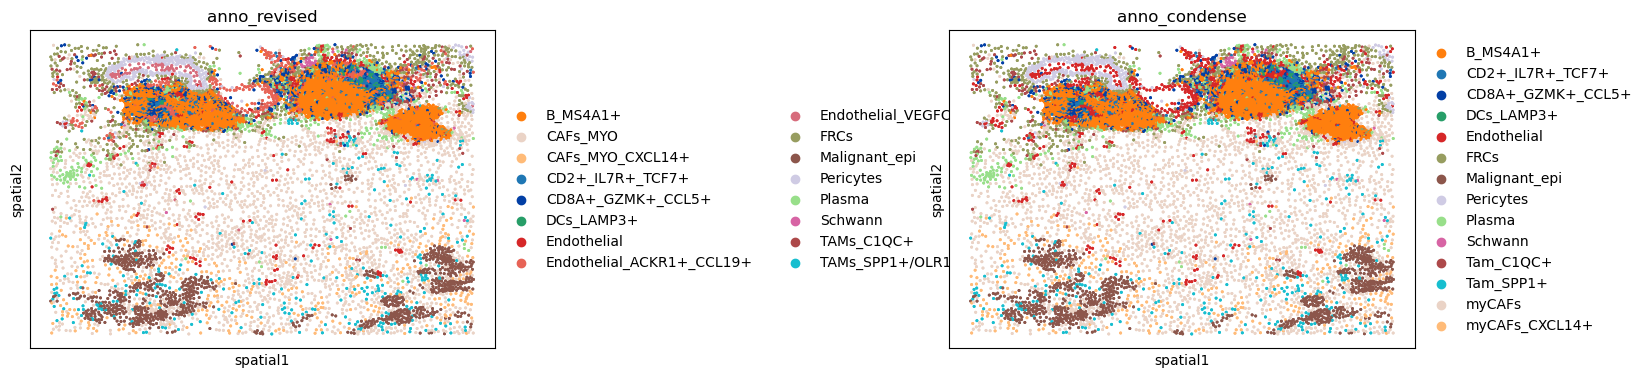

In [13]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    shape=None,
    size=5,
    color=[
        "anno_revised",
        "anno_condense"
    ],
    wspace=0.8,
    figsize = (5,12)
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

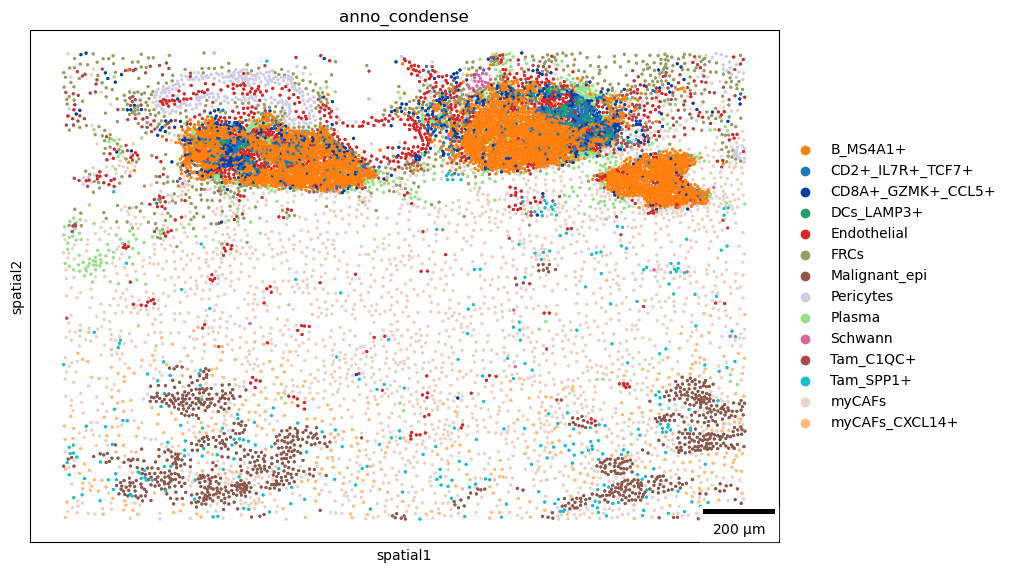

In [134]:
# Visualisation - at spatial context
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    shape=None,
    size=6,
    color=[
        "anno_condense"
    ],
    wspace=0.8,
    figsize = (10,12),
        scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    #save = 'output/Fig6A.pdf'
)

In [ ]:
genes = ['MS4A1','CD19','IGHM','IRF8','CXCL13',
         'CCL22','LAMP3','CCR7',
         'IL7R','TCF7','CD2',  
         'CD3E','CD8A','GZMK','GZMA','KLRG1','CCL5',
         'IGHG1','MZB1',
         'PLA2G2A','IGF1','NGFR',
          'CSF1R','CD163','C1QA','SELENOP', 'HLA-DMB',
         'VWF','PLVAP',
         'ACTA2','PDGFRB','CSPG4','ITGA1','RGS5',
         'SPP1','OLR1',
         'POSTN','MMP2','COL6A3','COL11A1',
         'CXCL14','IGFBP3',
         'ANXA1','KRT7','KRT19','MUC1',
         'CDH19','CHL1',
        ]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


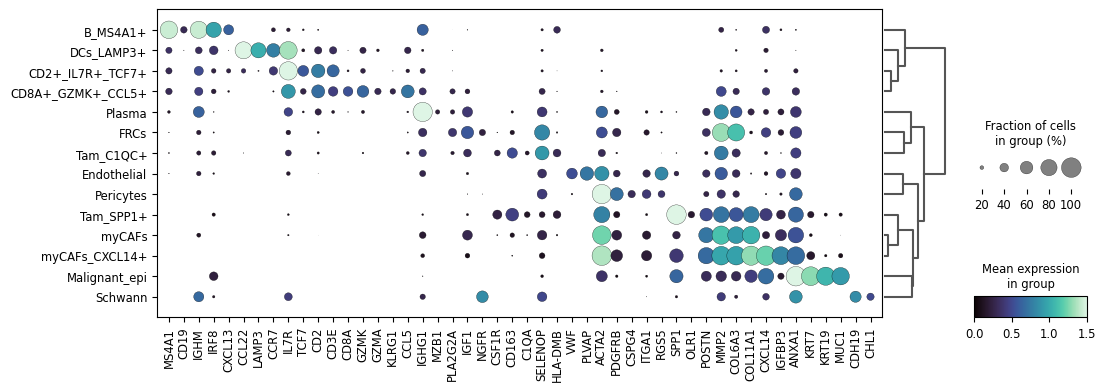

In [19]:
sc.pl.dotplot(subset_adata, var_names = genes , groupby='anno_condense', #swap_axes = True, 
              figsize=(12, 4), vmax=1.5, dot_min=0.1, cmap = 'mako',
             dendrogram=True)

In [ ]:
genes = ['MS4A1','CD19','IGHM','IRF8','CXCL13',
         'CCL22','LAMP3','CCR7',
         'IL7R','TCF7','CD2',  
         'CD3E','CD8A','GZMK','GZMA','KLRG1','CCL5',
         'ACTA2','PDGFRB','CSPG4','ITGA1','RGS5',
         'SPP1','OLR1',
          'POSTN','MMP2','COL6A3','COL11A1',#'IGF1',
         'CXCL14','IGFBP3',
         'ANXA1','KRT7','KRT19','MUC1',
         'CDH19','CHL1',
         'VWF','PLVAP', 'EFNB2','IGFBP3','VEGFC','IL33',
         'ACKR1','TGFBR3','CCL19','CCL21',
         'IGHG1','MZB1',#'SPAG4',
         'PLA2G2A','IGF1','NGFR',#'TNFSF14','PDPN','PDGFRA',
          'CSF1R','CD163','C1QA','SELENOP', 'HLA-DMB',]

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


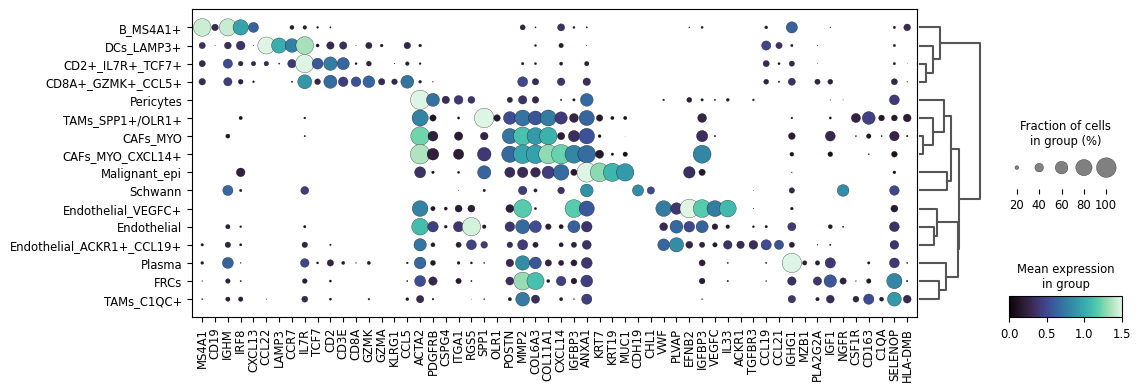

In [26]:
sc.pl.dotplot(subset_adata, var_names = genes , groupby='anno_revised', #swap_axes = True, 
              figsize=(12, 4), vmax=1.5, dot_min=0.1, cmap = 'mako',
             dendrogram=True, 
             save = 'Sup.Fig4.pdf'
             )

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

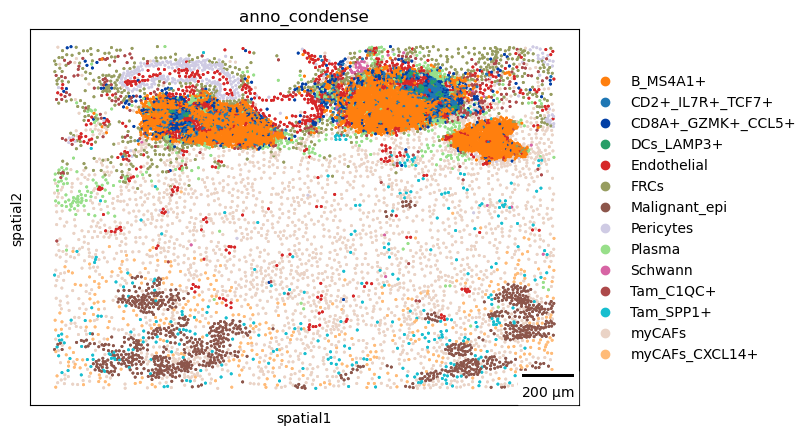

In [5]:
sq.pl.spatial_scatter(
    subset_adata, shape=None, color='anno_condense', size=5, library_id="spatial", figsize=(8, 10),
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    save = 'Fig6A.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/homevol/huemail/.local/lib/python3.9/site-pa

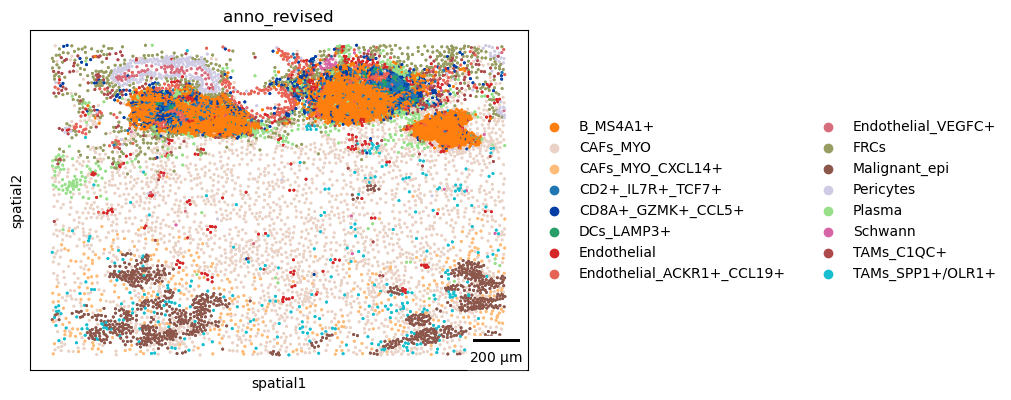

In [255]:
# Spatial distribution of cells
sq.pl.spatial_scatter(
    subset_adata, shape=None, color='anno_revised', size=5, library_id="spatial", figsize=(10, 10),
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    save = 'Fig6A.pdf'
)

In [185]:
cluster_counts = subset_adata.obs['anno'].value_counts()

# Calculate proportions
cluster_proportions = cluster_counts / len(subset_adata.obs)

# Display the result
print(cluster_proportions)

anno
B_IGHM+_IRF8+                0.189359
CAFs_MYO                     0.168024
B_MS4A1+_CXCL13+             0.124380
Malignant_epi                0.082064
FRCs                         0.060021
CAFs_IGF1+                   0.055772
CD8A+_GZMK+_CCL5+            0.048424
CD2+_IL7R+_TCF7+             0.048070
Plasma                       0.038421
Endothelial_ACKR1+_CCL19+    0.033817
CAFs_MYO_CXCL14+             0.033021
TAMs_SPP1+/OLR1+             0.027620
Endothelial                  0.024788
TAMs_C1QC+                   0.024699
Pericytes                    0.024256
DCs_LAMP3+                   0.007436
Endothelial_VEGFC+           0.006462
Schwann                      0.003364
Name: count, dtype: float64


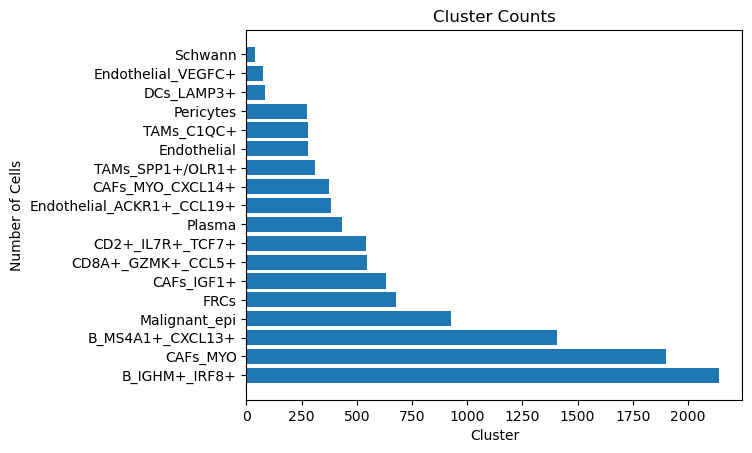

In [186]:
# Plot bar plot
#plt.bar(cluster_counts.index, cluster_counts.values)
plt.barh(cluster_counts.index, cluster_counts.values) # to swap axis
plt.xlabel('Cluster')
plt.ylabel('Number of Cells')
plt.title('Cluster Counts')
plt.show()

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 506.38/s]
/homevol/huemail/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as po

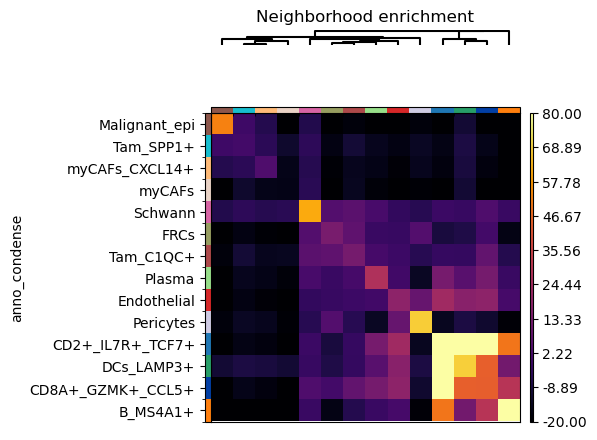

In [8]:
# Spatial analysis
# Neighbourhood enrichment analysis, clustering resolution definitely can be improved further 
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", spatial_key="spatial", radius=50) # can add radius and n_neighbour
sq.gr.nhood_enrichment(subset_adata, cluster_key="anno_condense", seed=184)
sq.pl.nhood_enrichment(
    subset_adata,
    cluster_key="anno_condense",
    method="average",
    cmap="inferno",
    vmin=-20,
    vmax=80,
    figsize=(4,4), 
    save = 'Fig6c_main.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

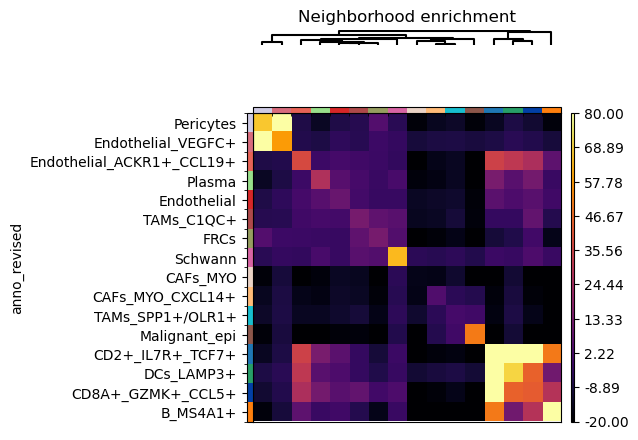

In [234]:
# Spatial analysis
# Neighbourhood enrichment analysis, clustering resolution definitely can be improved further 
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", spatial_key="spatial", radius=50) # can add radius and n_neighbour
sq.gr.nhood_enrichment(subset_adata, cluster_key="anno_revised", seed=2323)
sq.pl.nhood_enrichment(
    subset_adata,
    cluster_key="anno_revised",
    method="average",
    cmap="inferno",
    vmin=-20,
    vmax=80,
    figsize=(4,4), save = 'Fig6B.pdf'
)

In [6]:
sq.gr.co_occurrence(
    subset_adata,
    cluster_key="anno_condense",
    n_splits = 1, 
) 

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.97s/]


In [ ]:
subset_adata.uns['anno_condense_co_occurrence']

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

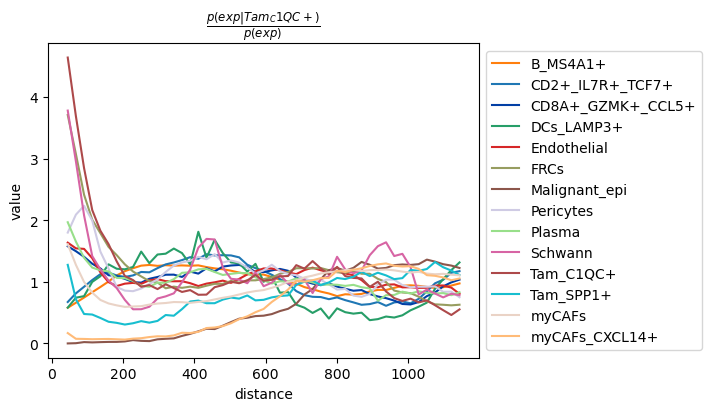

In [ ]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    subset_adata,
    cluster_key= "anno_condense",
    clusters= "Tam_C1QC+", # choose the cell type to focus on
    figsize=(7,4),
    #save = 'Pres2.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homevol/huemail/miniconda3/envs/xenium.squidpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

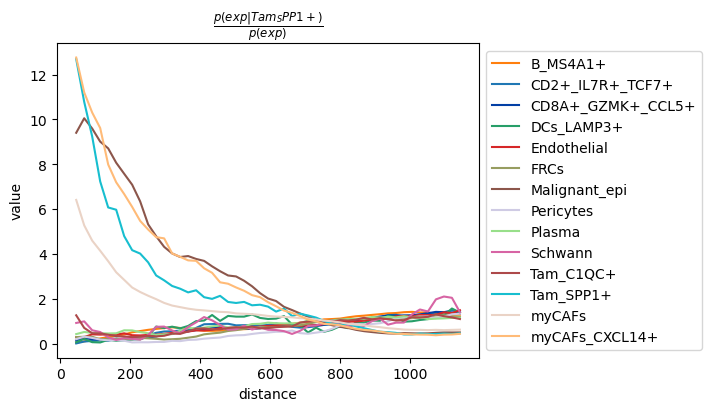

In [16]:
# Choosing the cell type to focus on
sq.pl.co_occurrence(
    subset_adata,
    cluster_key= "anno_condense",
    clusters= "Tam_SPP1+", # choose the cell type to focus on
    figsize=(7,4),
    #save = 'Pres1.pdf'
)

In [7]:
# Compute Moran's I score: to determine spatially variable genes
# The Moran’s I global spatial auto-correlation statistics evaluates whether features (i.e. genes) shows a pattern that is clustered, dispersed or random in the tissue are under consideration.
sq.gr.spatial_neighbors(subset_adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    subset_adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.84/s]


In [9]:
subset_adata.uns["moranI"].head(50) # top genes that show strong spatial patterning

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
FN1       0.805122        0.0   0.00003         0.0  0.009901  0.000068   
COL1A1    0.723625        0.0   0.00003         0.0  0.009901  0.000060   
KRT7      0.713301        0.0   0.00003         0.0  0.009901  0.000056   
COL11A1   0.708207        0.0   0.00003         0.0  0.009901  0.000060   
COL1A2    0.685191        0.0   0.00003         0.0  0.009901  0.000071   
KRT19     0.683519        0.0   0.00003         0.0  0.009901  0.000061   
THBS1     0.640960        0.0   0.00003         0.0  0.009901  0.000053   
EPCAM     0.638820        0.0   0.00003         0.0  0.009901  0.000065   
ACTA2     0.625609        0.0   0.00003         0.0  0.009901  0.000055   
MS4A1     0.615561        0.0   0.00003         0.0  0.009901  0.000066   
SERPINA1  0.611280        0.0   0.00003         0.0  0.009901  0.000066   
MUC1      0.605426        0.0   0.00003         0.0  0.009901  0.000065   
IGHM      0.603229        0.0   0.00003         0.0  0.009901  0.000059   
ANXA1     0.572865        0.0   0.00003         0.0  0.009901  0.000066   
CD74      0.570277        0.0   0.00003         0.0  0.009901  0.000054   
CCL22     0.565442        0.0   0.00003         0.0  0.009901  0.000046   
SPP1      0.545090        0.0   0.00003         0.0  0.009901  0.000055   
CXCL13    0.530630        0.0   0.00003         0.0  0.009901  0.000049   
CALD1     0.524391        0.0   0.00003         0.0  0.009901  0.000050   
TMPRSS4   0.476870        0.0   0.00003         0.0  0.009901  0.000049   
MUC5B     0.472196        0.0   0.00003         0.0  0.009901  0.000047   
KRT8      0.468807        0.0   0.00003         0.0  0.009901  0.000043   
POSTN     0.461591        0.0   0.00003         0.0  0.009901  0.000056   
MMP2      0.449428        0.0   0.00003         0.0  0.009901  0.000040   
CCL21     0.437242        0.0   0.00003         0.0  0.009901  0.000037   
IGHG1     0.433009        0.0   0.00003         0.0  0.009901  0.000041   
COL6A3    0.427443        0.0   0.00003         0.0  0.009901  0.000038   
HLA-B     0.422377        0.0   0.00003         0.0  0.009901  0.000041   
IRF8      0.414107        0.0   0.00003         0.0  0.009901  0.000045   
IDO1      0.399221        0.0   0.00003         0.0  0.009901  0.000035   
FXYD3     0.396054        0.0   0.00003         0.0  0.009901  0.000043   
LMO7      0.392583        0.0   0.00003         0.0  0.009901  0.000048   
SDC1      0.381775        0.0   0.00003         0.0  0.009901  0.000043   
IL7R      0.381079        0.0   0.00003         0.0  0.009901  0.000041   
C7        0.365513        0.0   0.00003         0.0  0.009901  0.000032   
HLA-E     0.364378        0.0   0.00003         0.0  0.009901  0.000040   
CD52      0.363688        0.0   0.00003         0.0  0.009901  0.000034   
CDH1      0.361205        0.0   0.00003         0.0  0.009901  0.000027   
AHNAK2    0.359794        0.0   0.00003         0.0  0.009901  0.000037   
RGS5      0.359090        0.0   0.00003         0.0  0.009901  0.000033   
CDH19     0.357502        0.0   0.00003         0.0  0.009901  0.000042   
VWF       0.341329        0.0   0.00003         0.0  0.009901  0.000028   
LAMP3     0.333803        0.0   0.00003         0.0  0.009901  0.000036   
PLA2G2A   0.327664        0.0   0.00003         0.0  0.009901  0.000033   
SELENOP   0.326618        0.0   0.00003         0.0  0.009901  0.000043   
CXCL14    0.326461        0.0   0.00003         0.0  0.009901  0.000041   
ONECUT2   0.321367        0.0   0.00003         0.0  0.009901  0.000044   
STK17B    0.316177        0.0   0.00003         0.0  0.009901  0.000031   
PLVAP     0.303031        0.0   0.00003         0.0  0.009901  0.000029   
GAS6      0.293487        0.0   0.00003         0.0  0.009901  0.000032   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
FN1                    0.0                0.0         0.011404  
COL1A1                 0.0                0.0         0.01140

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


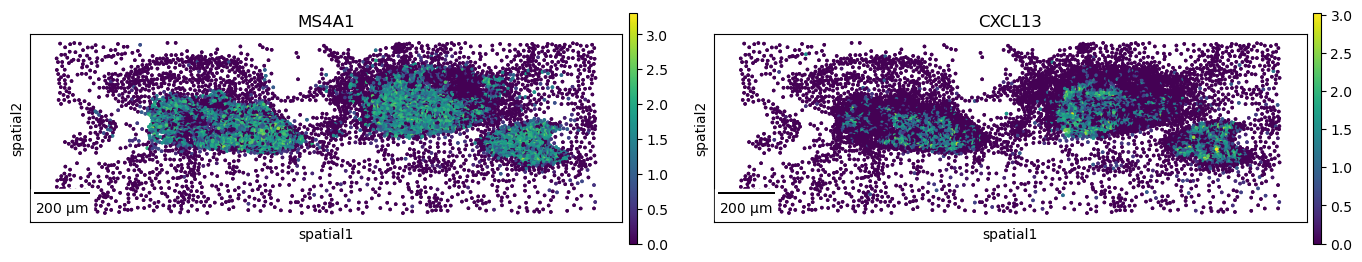

In [277]:
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=["MS4A1","CXCL13"],
    shape=None,
    crop_coord=[(2500, 700, 4400, 1300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10, figsize = (8, 3), wspace = 0.05,
    img=False, save = 'Fig6B_1.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


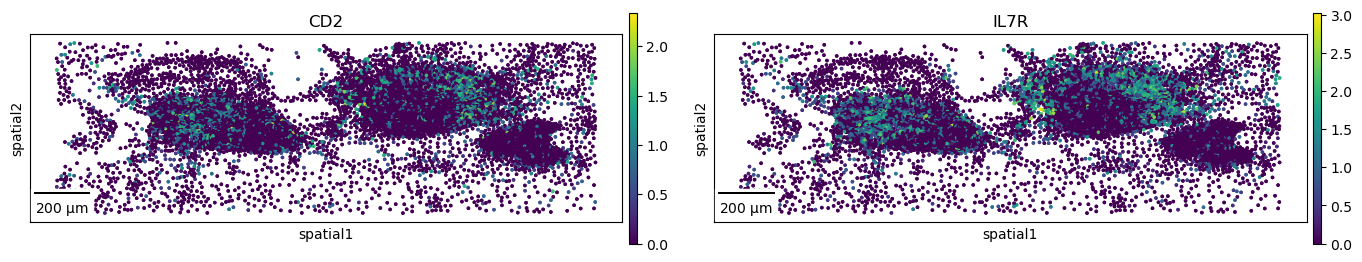

In [278]:
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=["CD2","IL7R"],
    shape=None,
    crop_coord=[(2500, 700, 4400, 1300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10, figsize = (8, 3), wspace = 0.05,
    img=False, save = 'Fig6B_2.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


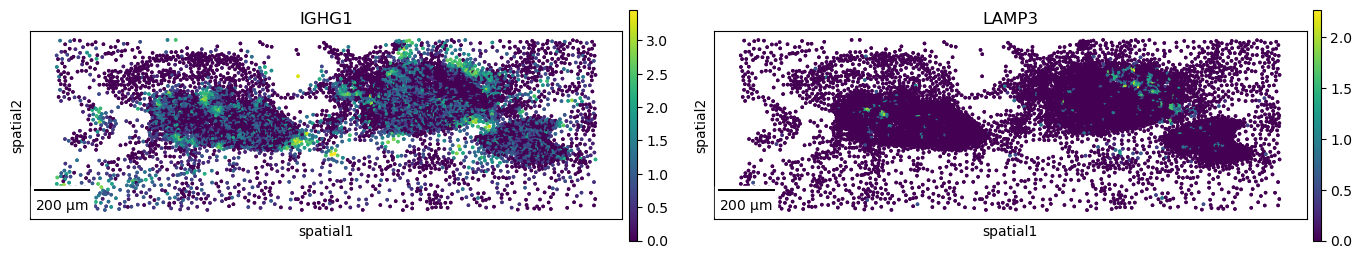

In [284]:
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "IGHG1","LAMP3"
    ],
    shape=None,
    crop_coord=[(2500, 700, 4400, 1300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10, figsize = (8, 3), wspace = 0.05,
    img=False, save = 'Fig6B_3.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


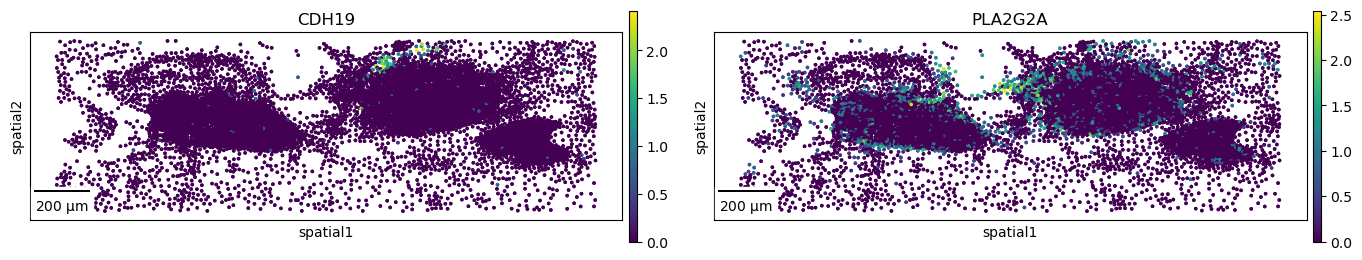

In [283]:
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "CDH19","PLA2G2A"
    ],
    shape=None,
    crop_coord=[(2500, 700, 4400, 1300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10, figsize = (8, 3), wspace = 0.05,
    img=False, save = 'Fig6B_4.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


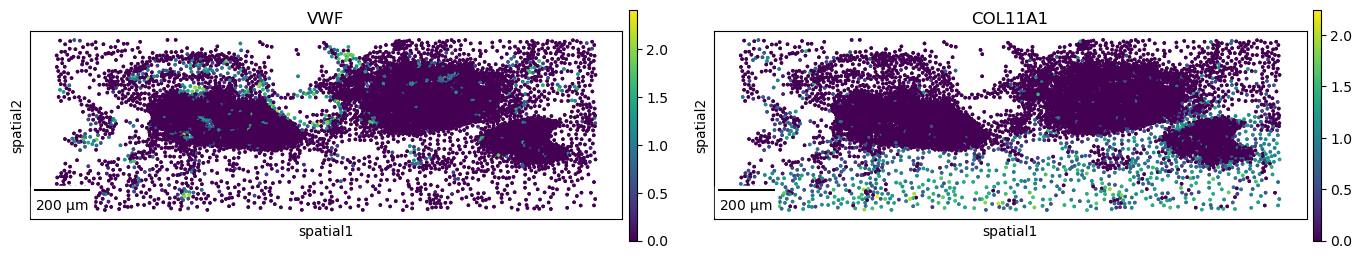

In [285]:
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "VWF","COL11A1"
    ],
    shape=None,
    crop_coord=[(2500, 700, 4400, 1300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10, figsize = (8, 3), wspace = 0.05,
    img=False, save = 'Fig6B_5.pdf'
)

/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/homevol/huemail/.local/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


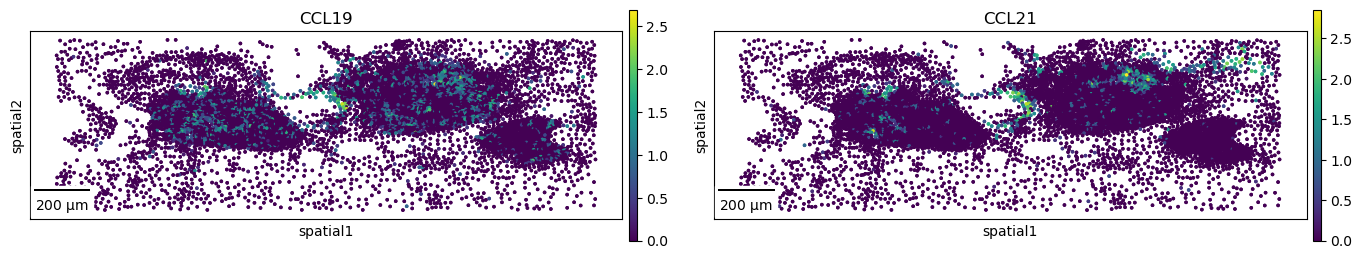

In [286]:
sq.pl.spatial_scatter(
    subset_adata,
    library_id="spatial",
    color=[
        "CCL19","CCL21"
    ],
    shape=None,
    crop_coord=[(2500, 700, 4400, 1300)], #(x0, right, x1, bottom).
    scalebar_dx = 1.0,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower left"},
    size=10, figsize = (8, 3), wspace = 0.05,
    img=False, save = 'Fig6B_6.pdf'
)

In [ ]:
TLS = subset_adata[subset_adata.obs['anno_condense'].isin(['B_MS4A1+', 'CD2+_IL7R+_TCF7+', 'CD8A+_GZMK+_CCL5+', 'DCs_LAMP3+',
       'Endothelial', 'FRCs','Plasma',
      'Tam_C1QC+'])] #'Schwann',

In [ ]:
# Running dendogram
sc.tl.dendrogram(TLS, groupby = "anno_revised")
sc.pl.dendrogram(TLS, groupby = "anno_revised")

In [21]:
TLS_cytokines = ['CXCL13','CCL19','CCL21','CCL22', 'TNFSF14',# TLS-cytokines
                 'ICAM1','CD80','CD274','CD28',
                 'CCL5','PRF1',
                 'TIGIT','CTLA4','HAVCR2',
                   'SIGLEC1','MERTK','C1QA','C1QC',
                    'MZB1','VWF', 'IL6',
                   'PDGFRA','CXCL2','CXCL14','PLA2G2A','IGF1', 'CSF1','PDPN','HAS1']

/homevol/huemail/.local/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


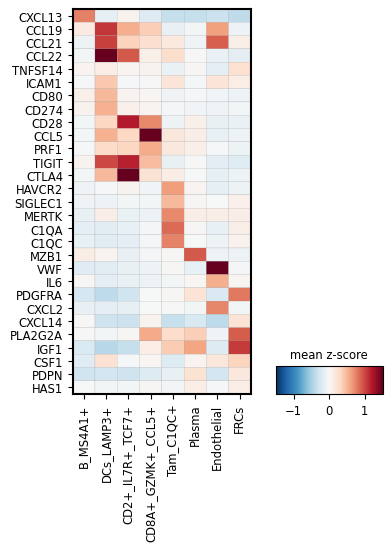

In [22]:
sc.pl.matrixplot(TLS, TLS_cytokines, groupby='anno_condense', dendrogram=False,swap_axes = True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-1.5, vmax=1.5, 
                 #cmap = 'viridis',
                 cmap='RdBu_r',  
                 categories_order = ['B_MS4A1+','DCs_LAMP3+','CD2+_IL7R+_TCF7+', 'CD8A+_GZMK+_CCL5+', 
                                     'Tam_C1QC+','Plasma','Endothelial','FRCs'], #'Schwann'],
                 figsize=(4,5), 
                 save = 'TLS_cytokines_1.pdf'
                ) 

In [27]:
pd.DataFrame(subset_adata.uns['anno_condense_nhood_enrichment']['zscore']) #50microns

0           1          2           3          4          5   \
0   152.364974   50.365848  28.185364   11.348389   1.447261 -15.434839   
1    50.365848  103.470723  81.261754  104.391550  23.181184  -9.961254   
2    28.185364   81.261754  42.936123   44.744552  17.746791   0.260877   
3    11.348389  104.391550  44.744552   69.753519  17.614228  -7.261661   
4     1.447261   23.181184  17.746791   17.614228  18.067082  -2.315285   
5   -15.434839   -9.961254   0.260877   -7.261661  -2.315285  13.011552   
6   -37.994705  -23.984178 -22.932202  -10.321925 -25.921277 -25.527396   
7   -18.028318  -13.802319 -11.390703   -8.033096   9.243711   4.386501   
8    -1.700160   13.213054  12.072915    5.495435   0.045122  -1.895273   
9    -1.954202   -1.326777   2.942255   -2.404211  -3.357702   3.966371   
10   -6.421079   -2.868875   8.008258   -3.014202  -1.140871   7.030297   
11  -20.867086  -16.965097 -15.373053   -8.048789 -16.369690 -16.048203   
12  -63.371399  -28.427638 -24.152991  -10.632431 -25.730236 -24.352962   
13  -24.431396  -18.024939 -18.089770   -9.131802 -17.811082 -18.394929   

           6          7          8          9          10         11  \
0  -37.994705 -18.028318  -1.700160  -1.954202  -6.421079 -20.867086   
1  -23.984178 -13.802319  13.213054  -1.326777  -2.868875 -16.965097   
2  -22.932202 -11.390703  12.072915   2.942255   8.008258 -15.373053   
3  -10.321925  -8.033096   5.495435  -2.404211  -3.014202  -8.048789   
4  -25.921277   9.243711   0.045122  -3.357702  -1.140871 -16.369690   
5  -25.527396   4.386501  -1.895273   3.966371   7.030297 -16.048203   
6   50.964735 -18.165366 -20.783197  -6.860950 -17.832080  -0.427859   
7  -18.165366  67.060538 -13.553390  -5.391476  -6.105307 -12.907322   
8  -20.783197 -13.553390  27.199653   1.576922   1.343147 -13.772441   
9   -6.860950  -5.391476   1.576922  64.333270   5.629696  -4.620235   
10 -17.832080  -6.105307   1.343147   5.629696  12.838374 -10.219108   
11  -0.427859 -12.907322 -13.772441  -4.620235 -10.219108   0.746416   
12 -26.511249 -18.107378 -17.815839  -4.995688 -14.472748 -11.581304   
13  -6.648456 -14.156092 -16.851778  -5.824346 -13.683659  -4.923604   

           12         13  
0  -63.371399 -24.431396  
1  -28.427638 -18.024939  
2  -24.152991 -18.089770  
3  -10.632431  -9.131802  
4  -25.730236 -17.811082  
5  -24.352962 -18.394929  
6  -26.511249  -6.648456  
7  -18.107378 -14.156092  
8  -17.815839 -16.851778  
9   -4.995688  -5.824346  
10 -14.472748 -13.683659  
11 -11.581304  -4.923604  
12 -15.697797 -16.030650  
13 -16.030650   3.466724

In [28]:
subset_adata.obs['anno_condense'].cat.categories

Index(['B_MS4A1+', 'CD2+_IL7R+_TCF7+', 'CD8A+_GZMK+_CCL5+', 'DCs_LAMP3+',
       'Endothelial', 'FRCs', 'Malignant_epi', 'Pericytes', 'Plasma',
       'Schwann', 'Tam_C1QC+', 'Tam_SPP1+', 'myCAFs', 'myCAFs_CXCL14+'],
      dtype='object')

In [29]:
from pathlib import Path  
df = pd.DataFrame(subset_adata.uns['anno_condense_nhood_enrichment']['zscore'])
df.columns = ['B_MS4A1+', 'CD2+_IL7R+_TCF7+', 'CD8A+_GZMK+_CCL5+', 'DCs_LAMP3+',
       'Endothelial', 'FRCs', 'Malignant_epi', 'Pericytes', 'Plasma',
       'Schwann', 'Tam_C1QC+', 'Tam_SPP1+', 'myCAFs', 'myCAFs_CXCL14+']
df.index = ['B_MS4A1+', 'CD2+_IL7R+_TCF7+', 'CD8A+_GZMK+_CCL5+', 'DCs_LAMP3+',
       'Endothelial', 'FRCs', 'Malignant_epi', 'Pericytes', 'Plasma',
       'Schwann', 'Tam_C1QC+', 'Tam_SPP1+', 'myCAFs', 'myCAFs_CXCL14+']

In [30]:
filepath = Path("../NhoodEnrichment_endocondense/P10617_1_50um.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 